In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, Concatenate, Multiply, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import cv2
import os

In [3]:
# Function to preprocess TIFF images
def preprocess_tiff(image_path, target_size, bands=[4, 3, 2], normalize=True):
    with rasterio.open(image_path) as src:
        bands_data = [src.read(band) for band in bands]
        rgb_image = np.dstack(bands_data)
        rgb_image = cv2.resize(rgb_image, target_size, interpolation=cv2.INTER_CUBIC)
        if normalize:
            rgb_image = np.clip(rgb_image, 0, 255) / 255.0  # Normalize to 0 to 1
    return rgb_image

# Function to load and preprocess standard images
def load_image(image_path, target_size=(1054, 1054), normalize=True):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file {image_path} does not exist.")
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Failed to load image {image_path}.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC)
    if normalize:
        image = image / 255.0  # Normalize to 0 to 1
    return image

In [4]:
# Generator class for data loading without LC information
class DataGenerator(Sequence):
    def __init__(self, hr_image_files, lr_dir='lr_images', hr_dir='hr_images', batch_size=16, target_size=(1054, 1054)):
        self.hr_image_files = hr_image_files
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.hr_image_files) / self.batch_size))

    def __getitem__(self, index):
        batch_hr_files = self.hr_image_files[index * self.batch_size:(index + 1) * self.batch_size]
        hr_images, lr_images = [], []
        
        for hr_file in batch_hr_files:
            hr_image_path = os.path.join(self.hr_dir, hr_file)
            base_name = hr_file.replace('_rgb.png', '')
            
            hr_image = load_image(hr_image_path)
            lr_image_file = f"{base_name}-L2A_data.tiff"
            lr_image_path = os.path.join(self.lr_dir, lr_image_file)
            lr_image = preprocess_tiff(lr_image_path, self.target_size)
            
            # No LC band in this version
            hr_image = np.clip(hr_image, 0, 1)
            lr_image = np.clip(lr_image, 0, 1)
            
            hr_splits = self.split_image(hr_image, (527, 527))
            lr_splits = self.split_image(lr_image, (527, 527))
            
            hr_images.extend(hr_splits)
            lr_images.extend(lr_splits)
        
        return np.array(lr_images), np.array(hr_images)

    def split_image(self, image, size=(527, 527)):
        h, w = image.shape[:2]
        split_images = []
        for i in range(0, h, size[0]):
            for j in range(0, w, size[1]):
                split_img = image[i:i + size[0], j:j + size[1]]
                split_images.append(split_img)
        return split_images

# Split the list of HR image filenames into training and testing sets
hr_image_files = [f for f in os.listdir('hr_images') if f.endswith('_rgb.png') and not f.startswith('.')]
train_files, test_files = train_test_split(hr_image_files, test_size=0.2, random_state=42)

# Initialize the data generators
train_generator = DataGenerator(train_files)
test_generator = DataGenerator(test_files)

In [72]:
# Define PSNR and SSIM metrics
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [6]:
# Create the SRCNN model
def create_model(input_shape=(527, 527, 3)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, (9, 9), activation='relu', padding='same')(inputs)
    x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    outputs = Conv2D(3, (5, 5), activation='linear', padding='same')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', psnr_metric, ssim_metric])
    return model

model = create_model(input_shape=(527, 527, 3))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 527, 527, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 527, 527, 64)      15616     
                                                                 
 conv2d_1 (Conv2D)           (None, 527, 527, 32)      2080      
                                                                 
 conv2d_2 (Conv2D)           (None, 527, 527, 3)       2403      
                                                                 
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_srcnn_model.h5', save_best_only=True, monitor='val_loss')

In [8]:
# Train the model
history = model.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
loss, accuracy, psnr, ssim = model.evaluate(test_generator)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}, Test PSNR: {psnr}, Test SSIM: {ssim}")

# Save the final model
model.save('srcnn_high_psnr.h5')

Epoch 1/20
43/43 [==============================] - 2565s 59s/step - loss: 0.0045 - mse: 0.0045 - psnr_metric: 24.6144 - ssim_metric: 0.6011 - val_loss: 0.0037 - val_mse: 0.0037 - val_psnr_metric: 25.1718 - val_ssim_metric: 0.6500
Epoch 2/20
43/43 [==============================] - 2578s 60s/step - loss: 0.0035 - mse: 0.0035 - psnr_metric: 25.5242 - ssim_metric: 0.6650 - val_loss: 0.0036 - val_mse: 0.0036 - val_psnr_metric: 25.4355 - val_ssim_metric: 0.6578
Epoch 3/20
43/43 [==============================] - 2575s 60s/step - loss: 0.0033 - mse: 0.0033 - psnr_metric: 25.8465 - ssim_metric: 0.6737 - val_loss: 0.0032 - val_mse: 0.0032 - val_psnr_metric: 25.9311 - val_ssim_metric: 0.6715
Epoch 4/20
43/43 [==============================] - 2616s 61s/step - loss: 0.0030 - mse: 0.0030 - psnr_metric: 26.4779 - ssim_metric: 0.6904 - val_loss: 0.0030 - val_mse: 0.0030 - val_psnr_metric: 26.4770 - val_ssim_metric: 0.6847
Epoch 5/20
43/43 [==============================] - 2606s 61s/step - loss: 0

In [11]:
# Evaluate the model on the test set
test_loss, test_mse, test_psnr, test_ssim = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")
print(f"Test PSNR: {test_psnr}")
print(f"Test SSIM: {test_ssim}")

11/11 [==============================] - 156s 14s/step - loss: 0.0029 - mse: 0.0029 - psnr_metric: 26.8264 - ssim_metric: 0.7025
Test Loss: 0.0029107138980180025
Test MSE: 0.002910713665187359
Test PSNR: 26.826406478881836
Test SSIM: 0.7024598717689514


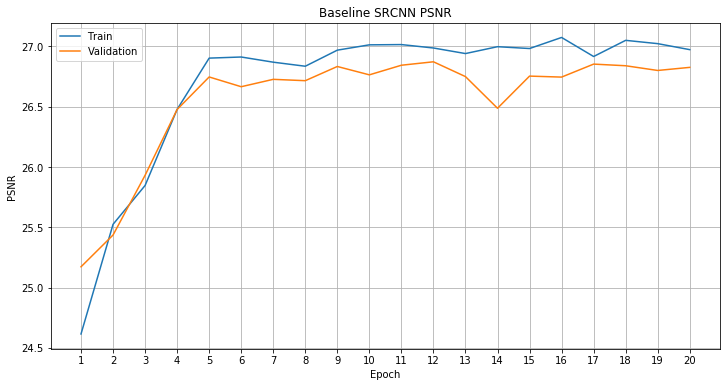

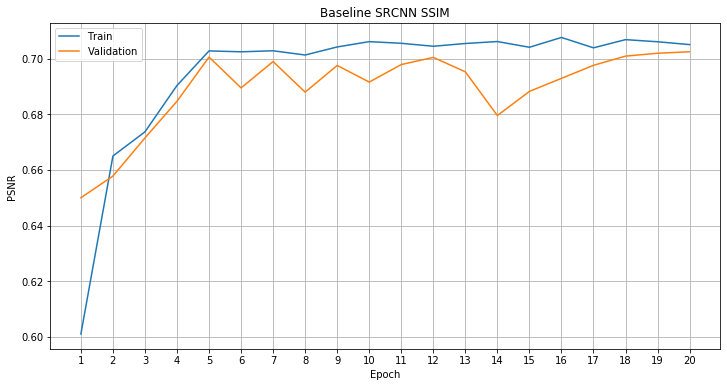

In [95]:
# Plot training & validation PSNR values
plt.figure(figsize=(12, 6))

# Generate x-axis values starting from 1 to the length of the history data
epochs = range(1, len(history.history['psnr_metric']) + 1)

# Plot the training and validation PSNR metrics
plt.plot(epochs, history.history['psnr_metric'])
plt.plot(epochs, history.history['val_psnr_metric'])

plt.title('Baseline SRCNN PSNR')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.grid(True)

# Set the x-axis ticks to be integer numbers
plt.xticks(epochs)

plt.legend(['Train', 'Validation'], loc='upper left')

# Save the plot to a file
plt.savefig('baseline_srcnn_psnr.png', dpi=300, bbox_inches='tight')

plt.show()

# Plot training & validation PSNR values
plt.figure(figsize=(12, 6))

# Generate x-axis values starting from 1 to the length of the history data
epochs = range(1, len(history.history['ssim_metric']) + 1)

# Plot the training and validation PSNR metrics
plt.plot(epochs, history.history['ssim_metric'])
plt.plot(epochs, history.history['val_ssim_metric'])

plt.title('Baseline SRCNN SSIM')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.grid(True)

# Set the x-axis ticks to be integer numbers
plt.xticks(epochs)

plt.legend(['Train', 'Validation'], loc='upper left')

# Save the plot to a file
plt.savefig('baseline_srcnn_ssim.png', dpi=300, bbox_inches='tight')

plt.show()

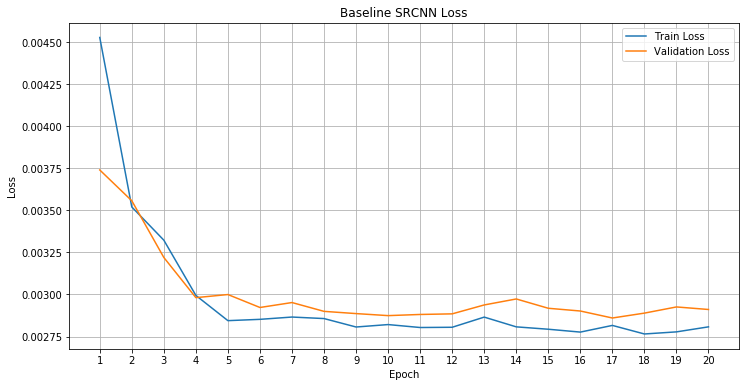

In [96]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Generate x-axis values starting from 1 to the length of the history data
epochs = range(1, len(history.history['loss']) + 1)

# Plot the training and validation loss metrics
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')

plt.title('Baseline SRCNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Set the x-axis ticks to be integer numbers
plt.xticks(epochs)

# Save the plot to a file
plt.savefig('baseline_srcnn_loss.png', dpi=300, bbox_inches='tight')

plt.show()

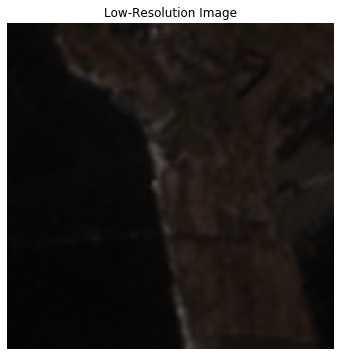

In [97]:
# Select a low-resolution image and enlarge it to the target size
lr_image_path = 'lr_images/Landcover-10236-L2A_data.tiff'
lr_image = preprocess_tiff(lr_image_path, target_size=(1054, 1054), normalize=False)

# Function to split an image into smaller patches
def split_image(image, size=(527, 527)):
    h, w = image.shape[:2]
    split_images = []
    for i in range(0, h, size[0]):
        for j in range(0, w, size[1]):
            split_img = image[i:i + size[0], j:j + size[1]]
            split_images.append(split_img)
    return split_images

# Split the enlarged low-resolution image into patches
lr_splits = split_image(lr_image)

# Select a patch for prediction
selected_lr_patch = lr_splits[2]

# Display the enlarged low-resolution image
plt.figure(figsize=(6, 6))
plt.imshow(selected_lr_patch)
plt.title('Low-Resolution Image')
plt.axis('off')

# Save the plot to a file
plt.savefig('example_lr_image.png', dpi=300, bbox_inches='tight')

plt.show()

1/1 [==============================] - 0s 115ms/step


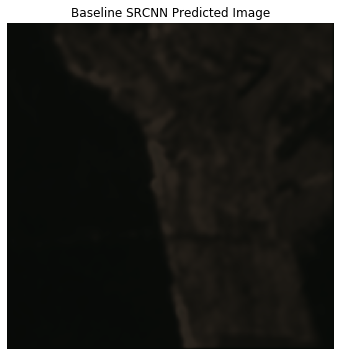

In [98]:
# Select a low-resolution image and enlarge it to the target size
lr_image_path = 'lr_images/Landcover-10236-L2A_data.tiff'
lr_image = preprocess_tiff(lr_image_path, target_size=(1054, 1054), normalize=True)

# Split the enlarged low-resolution image into patches
lr_splits = split_image(lr_image)

# Select a patch for prediction
selected_lr_patch = lr_splits[2]

# Predict using the model
predicted_patch = model.predict(np.expand_dims(selected_lr_patch, axis=0))[0]

# Display the predicted patch
plt.figure(figsize=(6, 6))
plt.imshow(np.clip(predicted_patch, 0, 1))  # Clip the predicted values between 0 and 1
plt.title('Baseline SRCNN Predicted Image')
plt.axis('off')

# Save the plot to a file
plt.savefig('example_baseline_srcnn_predicted_image.png', dpi=300, bbox_inches='tight')

plt.show()

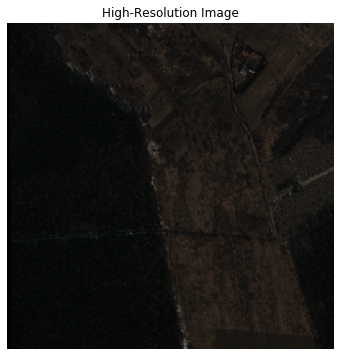

In [99]:
# Select the corresponding high-resolution image
hr_image_path = 'hr_images/Landcover-10236_rgb.png'
hr_image = load_image(hr_image_path, target_size=(1054, 1054), normalize=False)

# Split the enlarged low-resolution image into patches
hr_splits = split_image(hr_image)

selected_hr_patch = hr_splits[2]

# Display the enlarged low-resolution image
plt.figure(figsize=(6, 6))
plt.imshow(selected_hr_patch)
plt.title('High-Resolution Image')
plt.axis('off')

# Save the plot to a file
plt.savefig('example_hr_image.png', dpi=300, bbox_inches='tight')

plt.show()

2/2 [==============================] - 2s 248ms/step


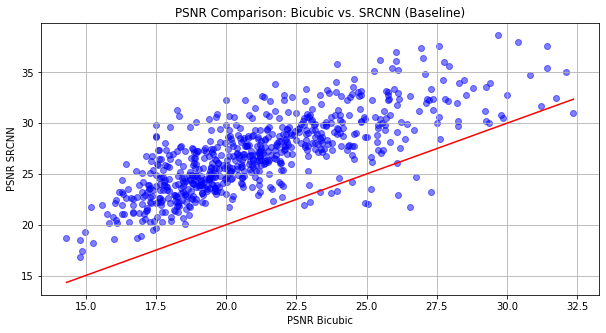

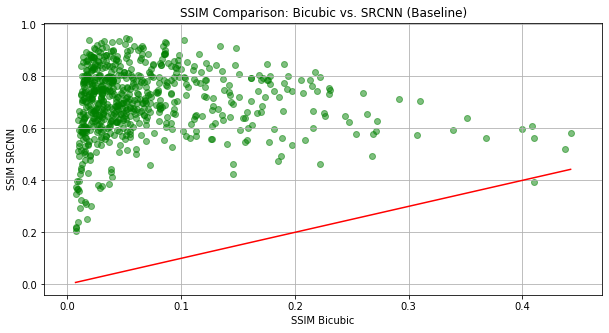

Average PSNR (Bicubic): 21.16 dB
Average PSNR (SRCNN): 26.83 dB
Average SSIM (Bicubic): 0.0688
Average SSIM (SRCNN): 0.7025


In [101]:
# Define PSNR and SSIM metrics with type conversion
def psnr_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)  # Convert to float64
    y_pred = tf.cast(y_pred, tf.float64)  # Convert to float64
    return tf.image.psnr(y_true, y_pred, max_val=1.0).numpy()

def ssim_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)  # Convert to float64
    y_pred = tf.cast(y_pred, tf.float64)  # Convert to float64
    return tf.image.ssim(y_true, y_pred, max_val=1.0).numpy()

# Function to calculate PSNR and SSIM for all patches in the test set (Baseline SRCNN)
def calculate_metrics_baseline(test_generator, model):
    psnr_bicubic_list = []
    psnr_srcnn_list = []
    ssim_bicubic_list = []
    ssim_srcnn_list = []

    # Iterate over the test generator
    for lr_patches, hr_patches in test_generator:
        # Predict the HR patches using the model
        predicted_patches = model.predict(lr_patches)

        # Iterate over each patch
        for j in range(len(hr_patches)):
            # Calculate PSNR and SSIM for the bicubic interpolation (used as baseline)
            psnr_bicubic = psnr_metric(hr_patches[j], lr_patches[j])
            ssim_bicubic = ssim_metric(hr_patches[j], lr_patches[j])

            # Calculate PSNR and SSIM for the SRCNN predicted output
            psnr_srcnn = psnr_metric(hr_patches[j], predicted_patches[j])
            ssim_srcnn = ssim_metric(hr_patches[j], predicted_patches[j])

            # Append metrics to lists
            psnr_bicubic_list.append(psnr_bicubic)
            psnr_srcnn_list.append(psnr_srcnn)
            ssim_bicubic_list.append(ssim_bicubic)
            ssim_srcnn_list.append(ssim_srcnn)

    # Convert lists to numpy arrays
    psnr_bicubic_list = np.array(psnr_bicubic_list)
    psnr_srcnn_list = np.array(psnr_srcnn_list)
    ssim_bicubic_list = np.array(ssim_bicubic_list)
    ssim_srcnn_list = np.array(ssim_srcnn_list)

    # Save the results for later comparison
    np.save('psnr_baseline.npy', psnr_srcnn_list)
    np.save('ssim_baseline.npy', ssim_srcnn_list)

    # Calculate average metrics
    avg_psnr_bicubic = np.mean(psnr_bicubic_list)
    avg_psnr_srcnn = np.mean(psnr_srcnn_list)
    avg_ssim_bicubic = np.mean(ssim_bicubic_list)
    avg_ssim_srcnn = np.mean(ssim_srcnn_list)

    # Plot PSNR comparison
    plt.figure(figsize=(10, 5))
    plt.scatter(psnr_bicubic_list, psnr_srcnn_list, color='blue', alpha=0.5)
    plt.plot([psnr_bicubic_list.min(), psnr_bicubic_list.max()], [psnr_bicubic_list.min(), psnr_bicubic_list.max()], color='red')
    plt.xlabel('PSNR Bicubic')
    plt.ylabel('PSNR SRCNN')
    plt.title('PSNR Comparison: Bicubic vs. SRCNN (Baseline)')
    plt.grid(True)
    
    # Save the plot to a file
    plt.savefig('psnr_comparison_bicubic_vs_srcnn_baseline.png', dpi=300, bbox_inches='tight')
    
    plt.show()

    # Plot SSIM comparison
    plt.figure(figsize=(10, 5))
    plt.scatter(ssim_bicubic_list, ssim_srcnn_list, color='green', alpha=0.5)
    plt.plot([ssim_bicubic_list.min(), ssim_bicubic_list.max()], [ssim_bicubic_list.min(), ssim_bicubic_list.max()], color='red')
    plt.xlabel('SSIM Bicubic')
    plt.ylabel('SSIM SRCNN')
    plt.title('SSIM Comparison: Bicubic vs. SRCNN (Baseline)')
    plt.grid(True)
    
    # Save the plot to a file
    plt.savefig('ssim_comparison_bicubic_vs_srcnn_baseline.png', dpi=300, bbox_inches='tight')
    
    plt.show()

    # Print average metrics
    print(f"Average PSNR (Bicubic): {avg_psnr_bicubic:.2f} dB")
    print(f"Average PSNR (SRCNN): {avg_psnr_srcnn:.2f} dB")
    print(f"Average SSIM (Bicubic): {avg_ssim_bicubic:.4f}")
    print(f"Average SSIM (SRCNN): {avg_ssim_srcnn:.4f}")

# Example usage
calculate_metrics_baseline(test_generator, model)


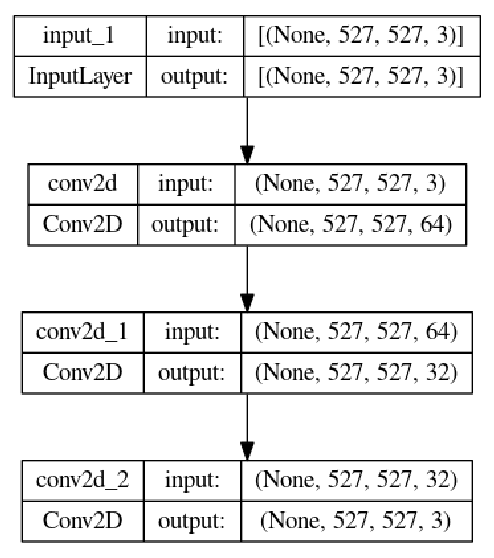

In [93]:
from tensorflow.keras.utils import plot_model

# Plot model
plot_model(model, to_file='baseline_srcnn_structure.png', show_shapes=True, show_layer_names=True)

# Display the model plot
img = plt.imread('baseline_srcnn_structure.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()